In [7]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import matplotlib.pyplot as plt

In [8]:
# Complete the following functions
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   return x_optimal, cash_optimal

def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    #calculation of portfolio value
    portfolio_V = np.dot(cur_prices, x_init) + cash_init
    #equal weight for the 20 stocks
    w = np.ones((20)) / 20      
    #equal allocation of money for each asset 
    each_asset_V = w * portfolio_V 
    #rounding procedure of number of shares  
    x_optimal = np.floor(each_asset_V / cur_prices)  
    #calculation of transaction cost
    tran_cost = np.dot(cur_prices, abs(x_optimal-x_init)) * 0.005
    #take transaction cost into account 
    cash_optimal = portfolio_V - np.dot(cur_prices, x_optimal) - tran_cost  
    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    #calculation of portfolio value
    portfolio_V = np.dot(cur_prices, x_init) + cash_init
    #create cplex object
    cpx = cplex.Cplex()  
    #set sense to minimize objective
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    #give c,lb,ub,A to cplex slover 
    c = np.zeros((20))
    lb = np.zeros((20))
    ub = np.ones((20))
    A = []
    for i in range(20):
        A.append([[0,1],[1,0]]) 
    var_names = ['w_%s'% i for i in range(1,21)]
    #add objective function, bounds on variables and constraint to cplex model
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EG')   
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)
    #define and add quadratic part of objective function
    Qmat = [[list(range(20)),list(2*Q[k,:])] for k in range(20)] 
    #set quadratic objective
    cpx.objective.set_quadratic(Qmat)   
    #set cplex parameters
    alg = cpx.parameters.lpmethod.values  
    cpx.parameters.qpmethod.set(alg.concurrent) 
    #disable the print of results and warnings
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    #optimize the problem
    cpx.solve()
    #optimal weights
    w = np.array(cpx.solution.get_values()) 
    #allocate money to each asset by their weights
    each_asset_V = w * portfolio_V
    #rounding procedure of number of shares   
    x_optimal = np.floor(each_asset_V / cur_prices) 
    #calculation of transaction cost
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    #take transaction cost into account
    cash_optimal = portfolio_V - np.dot(cur_prices,x_optimal) - tran_cost 
    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    #calculation of portfolio value
    portfolio_V = cur_prices.dot(x_init) + cash_init
    #annual risk-free rate for years 2020-2021 is 2.5%
    r_rf = 0.025
    #calculation of daily risk-free rate(252 trading days)
    r_rf_daily = 1.025**(1.0/252)-1   
    #add new column and row for the risk-free asset
    Q1 = np.append(Q,np.zeros((20,1)),axis=1)
    Q2 = np.vstack([Q1,np.zeros((21))])  
    #calculation of the difference between mu and daily risk-free rate
    SR_diff = mu-r_rf_daily * np.ones(20) 
    #create cplex object
    cpx = cplex.Cplex()  
    #set sense to minimize objective
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    #give c,lb,ub,A to cplex slover 
    c = [0]*21
    lb = [0]*21
    ub = [np.inf]*21
    A = []
    for i in range(20):
        A.append([[0,1],[SR_diff[i],1.0]])
    A.append([[0,1],[0,-1.0]]) 
    var_names = ['y_%s'% i for i in range(1,22)]
    #add objective function, bounds on variables and constraint to cplex model
    cpx.linear_constraints.add(rhs=[1.0,0],senses='EE') 
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)
    #define and add quadratic part of objective function
    Qmat = [[list(range(21)),list(2*Q2[k,:])] for k in range(21)]
    #set quadratic objective
    cpx.objective.set_quadratic(Qmat)
    #set cplex parameters
    alg = cpx.parameters.lpmethod.values  
    cpx.parameters.qpmethod.set(alg.concurrent) 
    #disable the print of results and warnings
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    #optimize the problem
    cpx.solve()
    w = np.array(cpx.solution.get_values())
    w = w[0:20]/w[20]
    #allocate money to each asset by their weights
    each_asset_V = w * portfolio_V   
    #rounding procedure of number of shares
    x_optimal = np.floor(each_asset_V / cur_prices)  
    #calculation of transaction cost
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    #take transaction cost into account 
    cash_optimal = portfolio_V - np.dot(cur_prices,x_optimal) - tran_cost 
    return x_optimal, cash_optimal

In [9]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      while cash[strategy, period-1] < 0:
            
            portfolio_V = np.dot(cur_prices, curr_positions) + curr_cash
            ratio = x[strategy][period-1]/np.sum(x[strategy][period-1])
            neg_cash = abs(cash[strategy][period-1])*ratio
            neg_position = np.ceil(neg_cash/cur_prices)
            x[strategy][period-1] = x[strategy][period-1] - neg_position
            new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
            cash[strategy, period-1] = portfolio_V - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost
            
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)



Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992742.20, value end = $ 916349.58
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.15, value end = $ 922082.60

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 956110.62, value end = $ 851538.63
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962066.45, value end = $ 1017225.05

Period 3: start date 05/01/2020, end date 06/30/2020
  Strategy "Buy and Hold", value begin = $ 937916.81, value end = $ 913415.30
 

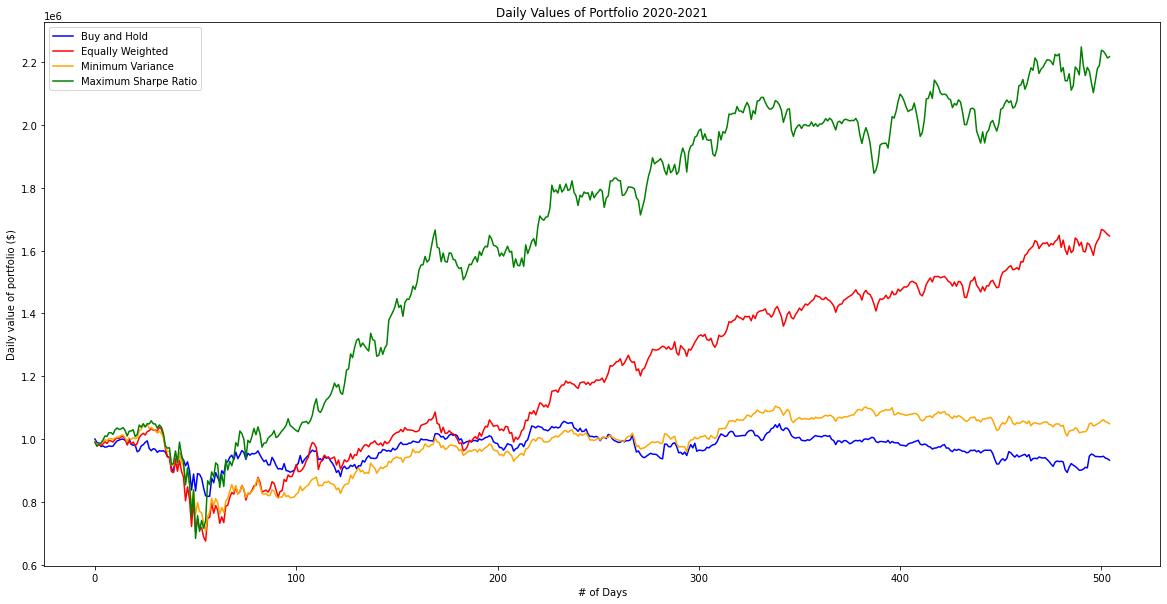

In [10]:
#Plot the daily value of the portfolio (for each trading strategy) over the years 2020 and 2021
plt.figure(figsize=(20,10))
plt.plot(portf_value[0], label='Buy and Hold', color='blue')
plt.plot(portf_value[1], label='Equally Weighted', color='red')
plt.plot(portf_value[2], label='Minimum Variance', color='orange')
plt.plot(portf_value[3], label='Maximum Sharpe Ratio', color='green')
plt.title('Daily Values of Portfolio 2020-2021')
plt.xlabel('# of Days')
plt.ylabel('Daily value of portfolio ($)')
plt.legend()
plt.show()

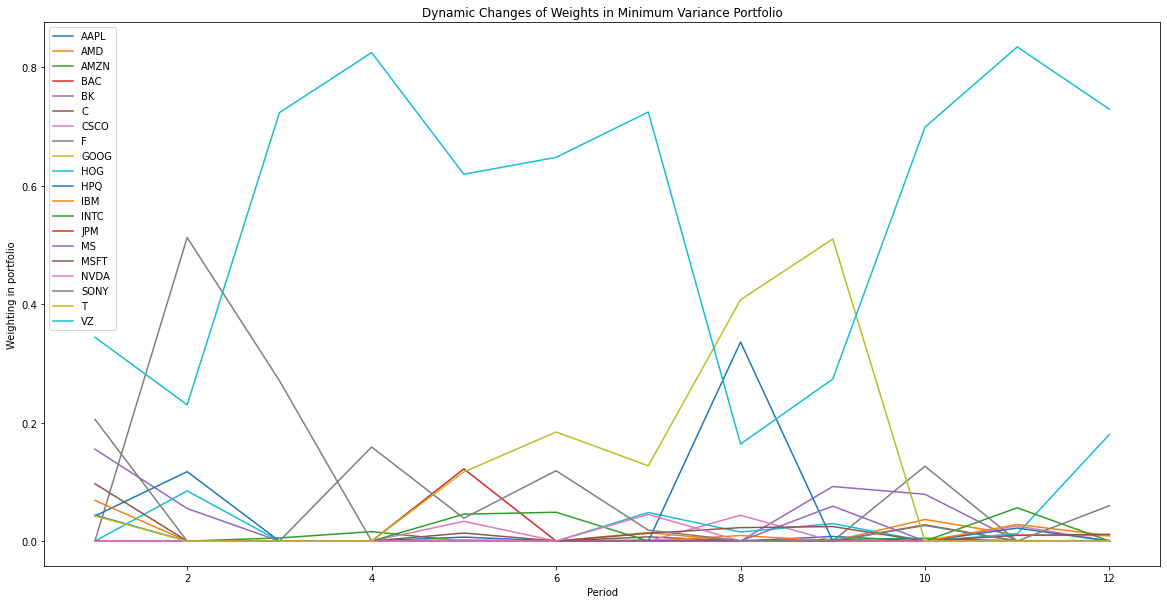

In [11]:
# Plot dynamic changes in portfolio allocations for minimize variance strategy
stocks = df.columns[1:]
w = []
for period in range(1, N_periods+1):
    w.append(x[2, period-1]/sum(x[2, period-1]))
df_minVar = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_minVar.plot(figsize=(20,10))
plt.title('Dynamic Changes of Weights in Minimum Variance Portfolio')
plt.xlabel('Period')
plt.ylabel('Weighting in portfolio')
plt.show()

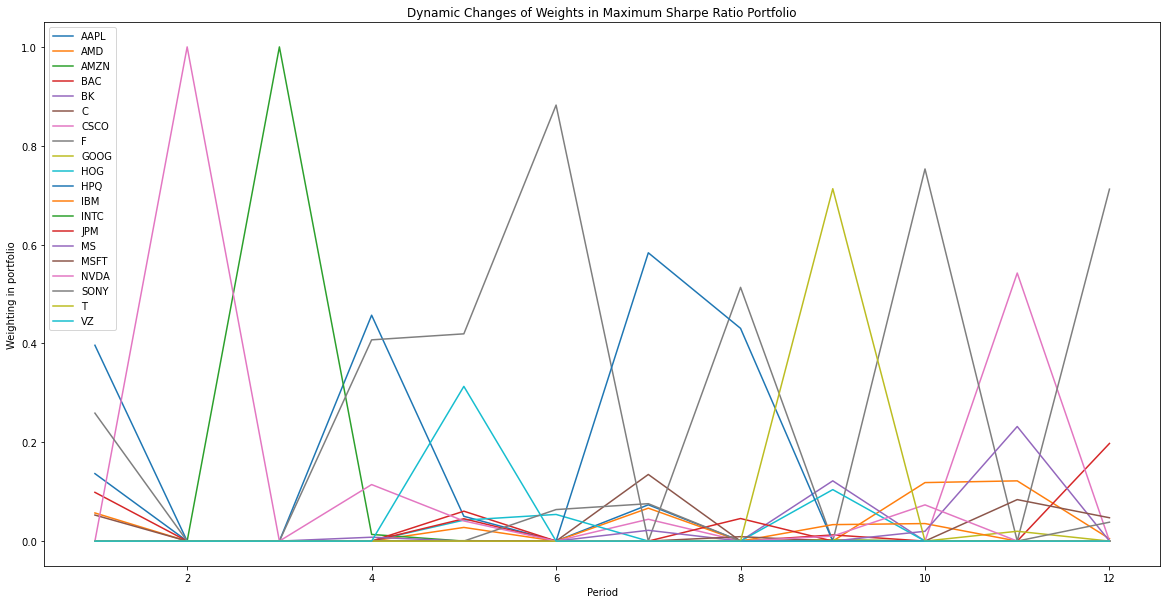

In [12]:
#Plot dynamic Changes in portfolio allocations for maximize Sharpe Ratio strategy 

stocks = df.columns[1:]
w = []
for period in range(1, N_periods+1):
    w.append(x[3, period-1]/sum(x[3, period-1]))
df_maxSR = pd.DataFrame(np.array(w), columns=stocks, index=[1,2,3,4,5,6,7,8,9,10,11,12])
df_maxSR.plot(figsize=(20,10))
plt.title('Dynamic Changes of Weights in Maximum Sharpe Ratio Portfolio')
plt.xlabel('Period')
plt.ylabel('Weighting in portfolio')
plt.show()

# Variation of strategies: select "1/n" portfolio at the beginning of period 1 and hold it till the end of period 12. 

In [13]:
portfolio_V = 1000012.93 
#equal weight for the 20 stocks
w = np.ones((20)) / 20   
cur_prices = data_prices[0,:] 
#equal allocation of money for each asset 
each_asset_V = w * portfolio_V 
#rounding procedure of number of shares 
x_optimal = np.floor(each_asset_V / cur_prices)  
print(x_optimal)

[ 675. 1018.   26. 1468. 1041.  659. 1097. 5425.   36. 1389. 2560.  426.
  864.  378. 1013.  317.  835.  724. 1507.  904.]


In [14]:
def strat_buy_and_hold_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    x_init = np.array(x_init)
    portfolio_V = np.dot(cur_prices,x_init) + cash_init
    x_optimal = [ 675., 1018.,   26., 1468., 1041.,  659., 1097., 5425.,   36.,
       1389., 2560.,  426.,  864.,  378., 1013.,  317.,  835.,  724.,
       1507.,  904.]
    tran_cost = np.dot(cur_prices , abs(x_optimal-x_init)) * 0.005
    cash_optimal = portfolio_V - np.dot(cur_prices,x_optimal) - tran_cost
    return np.array(x_optimal), cash_optimal

In [15]:
# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_buy_and_hold_equally_weighted']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Buy and Hold Equally Weighted']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_buy_and_hold_equally_weighted]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)
      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      while cash[strategy, period-1] < 0:
            
            portfolio_V = np.dot(cur_prices, curr_positions) + curr_cash
            ratio = x[strategy][period-1]/np.sum(x[strategy][period-1])
            neg_cash = abs(cash[strategy][period-1])*ratio
            neg_position = np.ceil(neg_cash/cur_prices)
            x[strategy][period-1] = x[strategy][period-1] - neg_position
            new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
            cash[strategy, period-1] = portfolio_V - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost
            
      # Compute portfolio value
      p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Initial portfolio value = $ 1000012.93


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000012.93, value end = $ 893956.75
  Strategy "Equally Weighted Portfolio", value begin = $ 990898.03, value end = $ 893204.97
  Strategy "Mininum Variance Portfolio", value begin = $ 992742.20, value end = $ 916349.58
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990064.15, value end = $ 922082.60
  Strategy "Buy and Hold Equally Weighted", value begin = $ 990898.03, value end = $ 893204.97

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 931389.80, value end = $ 862330.69
  Strategy "Mininum Variance Portfolio", value begin = $ 956110.62, value end = $ 851538.63
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 962066.45, value end = $ 1017225.05
  Strategy "Buy and Hold Equally Weigh

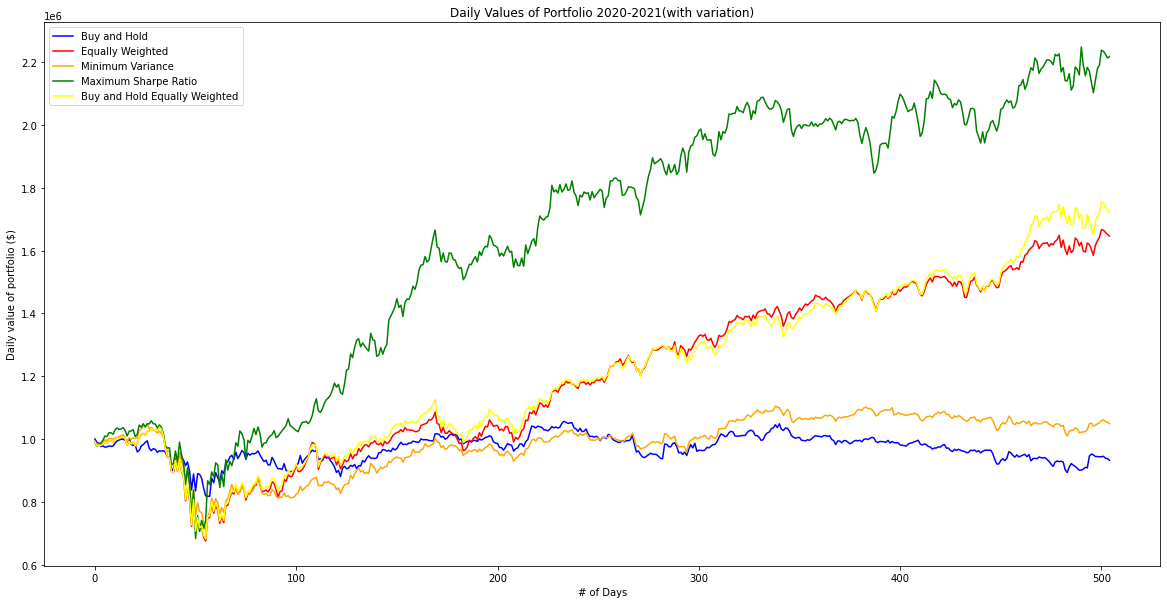

In [16]:
plt.figure(figsize=(20,10))
plt.plot(portf_value[0], label='Buy and Hold', color='blue')
plt.plot(portf_value[1], label='Equally Weighted', color='red')
plt.plot(portf_value[2], label='Minimum Variance', color='orange')
plt.plot(portf_value[3], label='Maximum Sharpe Ratio', color='green')
plt.plot(portf_value[4], label='Buy and Hold Equally Weighted', color='yellow')
plt.title('Daily Values of Portfolio 2020-2021(with variation)')
plt.xlabel('# of Days')
plt.ylabel('Daily value of portfolio ($)')
plt.legend()
plt.show()